In [1]:
#Importing Libraries
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

# Data Exploration

In [2]:
##filepath = "../input/classical-music-midi/chopin/"
cb = corpus.search('haydn')
#might not be useful
all_midis = []
for i in cb:
    midi = i.parse()
    all_midis.append(midi)
print(len(all_midis))

9


recurse() is used to loop through all notes in a stream

In [3]:
#This seems weird but ok       
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the haydn midis in the dataset:", len(Corpus))

Total notes in all the haydn midis in the dataset: 14095


In [4]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['B-3', 'B-3', 'B-3', 'B-2', 'B-3', 'B-3', 'B-3', 'B-2', 'D4', 'D4', 'D4', 'D3', 'D4', 'D4', 'D4', 'D3', 'F4', 'F4', 'F4', 'F3', 'F4', 'F4', 'F4', 'F3', 'B-4', 'B-4', 'B-4', 'B-3', 'B-4', 'B-4', 'B-4', 'B-3', 'F5', 'D5', 'F5', 'D5', 'B-5', 'G5', 'E-5', 'F5', 'D5', 'D5', 'B-4', 'F3', 'C5', 'A4', 'F3', 'D5', 'B-4', 'F3']


In [5]:
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 110


In [6]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 128.13636363636363
Most frequent note in Corpus appeared: 840 times
Least frequent note in Corpus appeared: 1 time


#### Plotting the distribution of notes

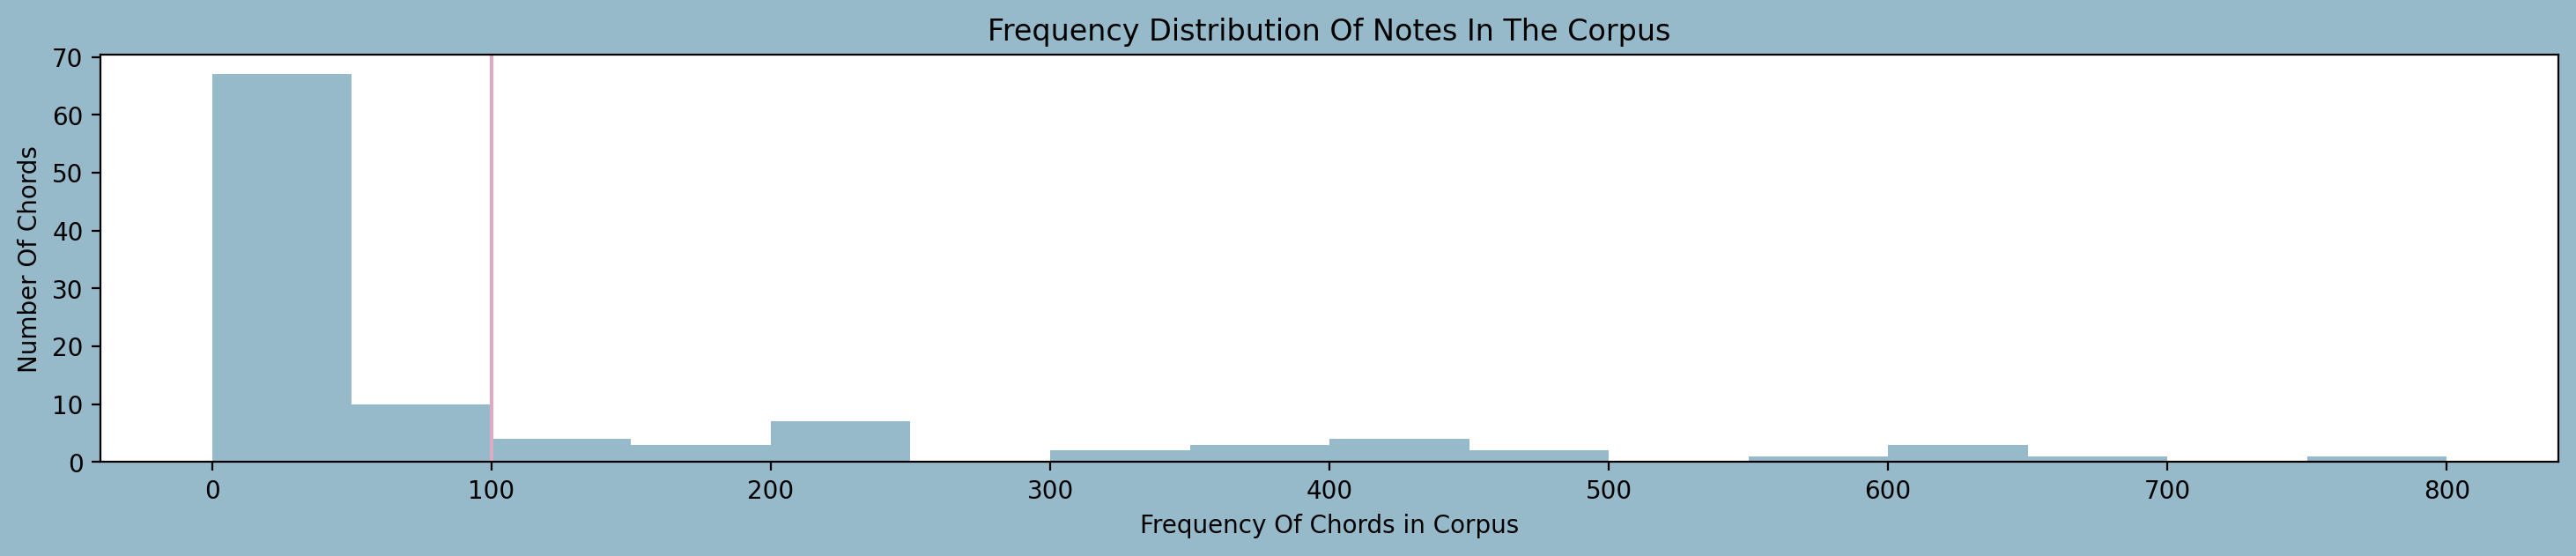

In [7]:
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

#### Getting a list of rare notes

In [8]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 77


#### Eliminating the rare notes

In [9]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 12852


# Data Preprocessing
Problems I have noticed until now: she just takes all notes into one long sequence. This ruins the song

In [10]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 12852
Number of unique characters: 88


In [11]:
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 12812


In [12]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets)

In [13]:
# Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Building

In [14]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 88)                22616     
                                                                 
Total params: 1,928,536
Trainable params: 1,928,536
Non-

In [16]:
#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=10)

Epoch 1/10
41/41 [==============================] - 213s 4s/step - loss: 3.7858
Epoch 2/10
41/41 [==============================] - 193s 5s/step - loss: 3.4990
Epoch 3/10
28/41 [===================>..........] - ETA: 1:08 - loss: 3.4934


KeyboardInterrupt

